## Tutorial 2: Instatiating a *scenario*

In this tutorial, we will cover the following items:

1. Create *actors*, *activities*, *events*, and *physical things*
2. Instantiate a *scenario*
3. Plot state and state derivative
4. Show all tags of the *scenario*
5. Use the `comprises` function of a *scenario category*
6. Export the objects

In [1]:
# Before starting, let us do the necessary imports
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from domain_model import Activity, activity_from_json, ActivityCategory, Actor, \
    ActorCategory, Constant, Linear, PhysicalThing, PhysicalThingCategory, \
    Scenario, scenario_from_json, scenario_category_from_json, Sinusoidal, Spline3Knots, \
    Splines, State, StateVariable, Tag, VehicleType

## 1. Create *actors*, *activities*, *events*, and *static physical things*

In this tutorial, we will create a *scenario* in which another vehicle changes lane such that it becomes the ego vehicle's leading vehicle. This is the quantitative counterpart of the *scenario category* that we created in the [previous tutorial](./Tutorial%201%20Scenario%20category.ipynb). The *scenario* is depicted in the figure below. Here, the blue car represents the ego vehicle and the red car represents the vehicle that performs the cut in.

<img src="./examples/images/cut-in.png" alt="Cut in" width="400"/>

Just as with a *scenario category*, we first need to create the components of a *scenario*. To create the *scenario*, we first need to create the *actors*, *activities*, *events*, and *physical things*. As we have already seen in the [previous tutorial](./Tutorial%201%20Scenario%20category.ipynb), the objects have a `name`, a `uid` (a unique ID), and `tags`. Additionally, these quantitative building blocks contain a reference to their qualitative counterparts.

### 1.1 Create *actors*

Now let us create the *actors*. We need the qualitative counterparts, the *actor categories*, and we will use the *actor categories* from the [previous tutorial](./Tutorial%201%20Scenario%20category.ipynb). Note that we can ignore the `uid` for now.

In [2]:
# First create the actor categories
EGO_VEHICLE_QUALITATIVE = ActorCategory(VehicleType.Vehicle, name="Ego vehicle", 
                                        tags=[Tag.EgoVehicle, Tag.RoadUserType_Vehicle])
TARGET_VEHICLE_QUALITATIVE = ActorCategory(VehicleType.Vehicle, name="Target vehicle",
                                           tags=[Tag.RoadUserType_Vehicle])

To instantiate an *actor*, the following arguments can be used:

- `category`: The corresponding *actor category* that we defined above.
- `initial_states` (optional): To create the actors, we can define the initial state. Because we will later quantify the speed of both actors as well as the lateral position using the activities, we will not define this now. However, the longitudinal position will not be defined by the activities, so we will use the `initial_states` to specify the initial longitudinal position. The ego vehicle starts at $x=0$ m and the target vehicle starts at $x=70$ m.
- `desired_states` (optional): For actors, the objective can be defined using the `desired_states`. For now, we will set the target for both vehicles at $x=400$ m and $y=0$ m. The ego vehicle's objective is to maintain the speed of $v=28$ m/s, while the target vehicle's objective is to drive at a speed of $v=22$ m/s. 
- `properties` (optional): Any properties can be described using a Python dictionary.
- `name` (optional): You can give the activity a meaningful name.
- `uid` (optional): If not given, a (random) unique ID will be created.
- `tags` (optional): If not given, an empty list is assumed. A bit more on this later.

In [3]:
EGO_VEHICLE = Actor(EGO_VEHICLE_QUALITATIVE, 
                    initial_states=[State(StateVariable.LONGITUDINAL_POSITION, 0)],
                    desired_states=[State(StateVariable.LONGITUDINAL_POSITION, 400),
                                    State(StateVariable.LATERAL_POSITION, 0),
                                    State(StateVariable.SPEED, 28)],
                    properties=dict(color="blue"),
                    name="ego vehicle")
TARGET_VEHICLE = Actor(TARGET_VEHICLE_QUALITATIVE,
                       initial_states=[State(StateVariable.LONGITUDINAL_POSITION, 70)],
                       desired_states=[State(StateVariable.LONGITUDINAL_POSITION, 400),
                                       State(StateVariable.LATERAL_POSITION, 0),
                                       State(StateVariable.SPEED, 22)],
                       properties=dict(color="red"),
                       name="target vehicle")

Note that we have not provided any tags to the *actors*. The idea behind that is that it would be inefficient if we would provide the tags for both the *actor categories* and the *actors*. Therefore, each object that can have tags (i.e., if the object is member of the `Thing` class), it has the functionality `get_tags()`. In case of the *actor categories*, this simply returns the tags of the *actor categories*. In case of the *actors*, however, it returns the tags of both the *actor* itself (in this case, we have not provided any tags directly) and the tags of the corresponding *actor categories*.

In [4]:
# Demonstrate the use of the `get_tags()` functionality.
print(EGO_VEHICLE.get_tags())

[<Tag.EgoVehicle: 13>, <Tag.RoadUserType_Vehicle: 1>]


### 1.2 Create *activities* and *events*

As with the actors, we first need to create the *activity categories*. We will create *activity categories* for the following type of activities:

- Cruising
- Decelerating
- Accelerating
- Following lane
- Changing lane

To demonstrate the use of the different models, we will use a different model for each *activity category*.

In [5]:
# First create the activity categories
CRUISING_CATEGORY = ActivityCategory(
    Constant(), StateVariable.SPEED, name="Cruising",
    description="Cruising at a constant positive speed",
    tags=[Tag.VehicleLongitudinalActivity_DrivingForward_Cruising])
BRAKING_CATEGORY = ActivityCategory(
    Sinusoidal(), StateVariable.SPEED, name="Braking",
    description="Decelerating to a lower speed",
    tags=[Tag.VehicleLongitudinalActivity_DrivingForward_Braking])
ACCELERATING_CATEGORY = ActivityCategory(
    Splines(), StateVariable.SPEED, name="Acccelerating",
    description="Accelerating to a higher speed",
    tags=[Tag.VehicleLongitudinalActivity_DrivingForward_Accelerating])
FOLLOWING_LANE_CATEGORY = ActivityCategory(
    BRAKING_CATEGORY.model, StateVariable.LATERAL_POSITION, name="Following lane",
    description="Stay in one lane",
    tags=[Tag.VehicleLateralActivity_GoingStraight])
CHANGING_LANE_CATEGORY = ActivityCategory(
    Spline3Knots(), StateVariable.LATERAL_POSITION, name="Changing lane",
    description="Change one lane to the left or to the right",
    tags=[Tag.VehicleLateralActivity_ChangingLane])

To instantiate an *activity*, the following arguments can be used:

- `category`: The corresponding *activity category* that we defined above.
- `parameters`: A dictionary with the parameters that are used to evaluate the model that has been defined in the corresponding *activity category*. To see which parameters are required, type `help(model)`, where `model` is to be replaced by the actual model. For example, `help(Sinusoidal)` will print the documentation of the `Sinusoidal` model.
- `start`: The starting event of the activity. Alternatively, instead of an `Event`, a single value can be passed. In that case, it is assumed that the activity starts when the time equals the provided value. In that case, an *event* is created at that particular time.
- `end`: The end event. Just as with `start`, a single value can be provided in which case an *event* is automatically instantiated.
- `name` (optional): You can give the activity a meaningful name.
- `uid` (optional): If not given, a (random) unique ID will be created.
- `tags` (optional): If not given, an empty list is assumed. Note that the `get_tags()` functionality works the same as for the *actors*, meaning that also the tags of the *activity category* are returned.

In [6]:
CRUISING_EGO1 = Activity(CRUISING_CATEGORY, dict(xstart=28), start=0, end=5, 
                         name="Initial cruising ego")
BRAKING_EGO = Activity(BRAKING_CATEGORY, dict(xstart=28, xend=20), start=CRUISING_EGO1.end, 
                       end=10, name="Braking ego")
ACCELERATING_EGO = Activity(ACCELERATING_CATEGORY, 
                            dict(knots=[0, 0, 0, 0, .5, 1, 1, 1, 1],
                                 coefficients=[20, 20, 21, 22, 22, 0, 0, 0, 0], degree=3),
                            start=BRAKING_EGO.end, end=13, name="Accelerating ego")
CRUISING_EGO2 = Activity(CRUISING_CATEGORY, dict(xstart=22), start=ACCELERATING_EGO.end,
                         end=15, name="Final cruising ego")
STRAIGHT_EGO = Activity(FOLLOWING_LANE_CATEGORY, dict(xstart=1.4, xend=1.6),
                        start=CRUISING_EGO1.start, end=CRUISING_EGO2.end, name="Following lane ego")
CRUISING_TARGET = Activity(CRUISING_CATEGORY, dict(xstart=22), start=CRUISING_EGO1.start,
                           end=CRUISING_EGO2.end, name="Cruising target")
STRAIGHT_TARGET1 = Activity(FOLLOWING_LANE_CATEGORY, dict(xstart=-1.6, xend=-1.5),
                            start=CRUISING_EGO1.start, end=3, name="Initial following lane target")
LANE_CHANGE_TARGET = Activity(CHANGING_LANE_CATEGORY, 
                              dict(a1=12, b1=0, c1=0, d1=-1.5, a2=12, b2=-36, c2=36, d2=-10.5),
                              start=STRAIGHT_TARGET1.end, end=7, name="Lane change target",
                              tags=[Tag.VehicleLateralActivity_ChangingLane_Left])
STRAIGHT_TARGET2 = Activity(FOLLOWING_LANE_CATEGORY, dict(xstart=1.5, xend=1.6),
                            start=LANE_CHANGE_TARGET.end, end=CRUISING_EGO2.end,
                            name="Final following lane target")

Note that the parameters for the `Spline3Knots` and `Splines` models (see `ACCELERATING_EGO` and `LANE_CHANGE_TARGET`) are not very intuitive. For now, you have to assume that these parameters make sense. In a later tutorial, we will see how these parameters can be determined in an alternative manner that might be more practical.

### 1.3 Create *physical things*

Just as with the tutorial on creating a *scenario category*, we only consider one *physical thing* that describes the road layout. For simplicitly, we assume a straight motorway road with 2 lanes of 3 m. The road is 400 m long.

In [7]:
# First create the physical thing category
MOTORWAY_CATEGORY = PhysicalThingCategory(description="Motorway with multiple lanes",
                                          name="Motorway",
                                          tags=[Tag.RoadLayout_Straight,
                                                Tag.RoadType_PrincipleRoad_Motorway])

In [8]:
MOTORWAY = PhysicalThing(MOTORWAY_CATEGORY,
                         properties=dict(nlanes=2, lanewidth=3, xydata=[[0, 0], [400, 0]]),
                         name="Motorway")

## 2 Instantiate a *scenario*

Instantiating a *scenario* is very similar to instantiating a *scenario category*. One of the difference is that we need to provide the events that mark the start and the end of the scenario. After creating the *scenario*, we can define the physical things, actors, activities, and acts using the functions `set_physical_things`, `set_actors`, `set_activities`, and `set_acts`, such as we did for the *scenario category* using the respective qualitative descriptions.

In [9]:
CUTIN = Scenario(start=CRUISING_EGO1.start, end=CRUISING_EGO2.end, name="cut-in scenario")
CUTIN.set_physical_things([MOTORWAY])
CUTIN.set_actors([EGO_VEHICLE, TARGET_VEHICLE])
CUTIN.set_activities([CRUISING_EGO1, BRAKING_EGO, ACCELERATING_EGO, CRUISING_EGO2,
                      STRAIGHT_EGO, CRUISING_TARGET, 
                      STRAIGHT_TARGET1, LANE_CHANGE_TARGET, STRAIGHT_TARGET2])
CUTIN.set_acts([(EGO_VEHICLE, CRUISING_EGO1),
                (EGO_VEHICLE, BRAKING_EGO),
                (EGO_VEHICLE, ACCELERATING_EGO),
                (EGO_VEHICLE, CRUISING_EGO2),
                (EGO_VEHICLE, STRAIGHT_EGO),
                (TARGET_VEHICLE, CRUISING_TARGET),
                (TARGET_VEHICLE, STRAIGHT_TARGET1),
                (TARGET_VEHICLE, LANE_CHANGE_TARGET),
                (TARGET_VEHICLE, STRAIGHT_TARGET2)])

## 3. Plot state and state derivative

With the provided models and parameters for describing how the state variables change over time, it is possible to obtain the values of these state variables at any point within the scenario. This can be done per *activity* or directly for a *scenario*. Here, we will show how this can be done for a *scenario*. 

A *scenario* has a `get_state` function that takes three input arguments:

- The actor for which we want to get the values of a state variable.
- The state variable that we want to obtain.
- The time instant for which we want to obtain the values. This can be single time or a list of times.

In the following example, we create a vector of time values starting at the start of the scenario (obtained using the `get_tstart` function) until the end of the scenario (obtained using the `get_tend` function).

In [10]:
TIME = np.linspace(CUTIN.get_tstart(), CUTIN.get_tend(), 100)

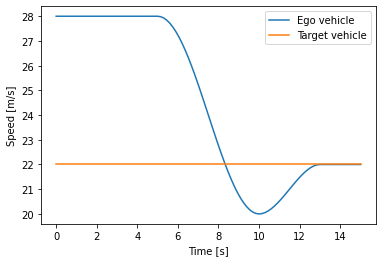

In [11]:
EGO_SPEED = CUTIN.get_state(EGO_VEHICLE, StateVariable.SPEED, TIME)
TARGET_SPEED = CUTIN.get_state(TARGET_VEHICLE, StateVariable.SPEED, TIME)
plt.plot(TIME, EGO_SPEED, label="Ego vehicle")
plt.plot(TIME, TARGET_SPEED, label="Target vehicle")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.show()

In a similar manner, we can obtain the derivative of a state variable. The only difference is that we need to use `get_state_dot` instead of `get_state`. 

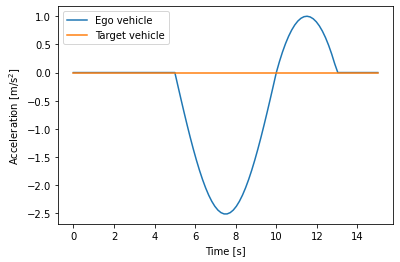

In [12]:
EGO_ACCELERATION = CUTIN.get_state_dot(EGO_VEHICLE, StateVariable.SPEED, TIME)
TARGET_ACCELERATION = CUTIN.get_state_dot(TARGET_VEHICLE, StateVariable.SPEED, TIME)
plt.plot(TIME, EGO_ACCELERATION, label="Ego vehicle")
plt.plot(TIME, TARGET_ACCELERATION, label="Target vehicle")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [m/s$^2$]")
plt.show()

## 4 Show all tags of the *scenario*

In the previous tutorial, we demonstrated the `derived_tags` functionality of a scenario category. We can do the same for the *scenario*.

In [13]:
CUTIN.derived_tags()

{'ego vehicle::Actor': [<Tag.VehicleLongitudinalActivity_DrivingForward_Cruising: 26>,
  <Tag.VehicleLongitudinalActivity_DrivingForward_Braking: 25>,
  <Tag.VehicleLongitudinalActivity_DrivingForward_Accelerating: 27>,
  <Tag.VehicleLateralActivity_GoingStraight: 14>,
  <Tag.RoadUserType_Vehicle: 1>,
  <Tag.EgoVehicle: 13>],
 'target vehicle::Actor': [<Tag.VehicleLongitudinalActivity_DrivingForward_Cruising: 26>,
  <Tag.VehicleLateralActivity_ChangingLane: 15>,
  <Tag.VehicleLateralActivity_GoingStraight: 14>,
  <Tag.RoadUserType_Vehicle: 1>,
  <Tag.VehicleLateralActivity_ChangingLane_Left: 16>],
 'Motorway::PhysicalThing': [<Tag.RoadLayout_Straight: 131>,
  <Tag.RoadType_PrincipleRoad_Motorway: 65>]}

To print the tags in a more readable manner, we can utilize the `print_tags` function.

In [14]:
CUTIN.print_tags()

Tags:
├─ ego vehicle::Actor
│  ├─ VehicleLongitudinalActivity_DrivingForward_Cruising
│  ├─ VehicleLongitudinalActivity_DrivingForward_Braking
│  ├─ VehicleLongitudinalActivity_DrivingForward_Accelerating
│  ├─ VehicleLateralActivity_GoingStraight
│  ├─ RoadUserType_Vehicle
│  └─ EgoVehicle
├─ target vehicle::Actor
│  ├─ VehicleLongitudinalActivity_DrivingForward_Cruising
│  ├─ VehicleLateralActivity_ChangingLane
│  ├─ VehicleLateralActivity_GoingStraight
│  ├─ RoadUserType_Vehicle
│  └─ VehicleLateralActivity_ChangingLane_Left
└─ Motorway::PhysicalThing
   ├─ RoadLayout_Straight
   └─ RoadType_PrincipleRoad_Motorway



## 5 Use the comprises function of a *scenario category*

If a specific *scenario category* is a qualitative description of a *scenario*, we can say that the *scenario category* "comprises" the *scenario*. To check whether a *scenario category* comprises a specific *scenario*, the `comprise` function of a *scenario category* can be used. This function checks the tags that are returned by the `derived_tags` functionality. Any of the tags from the *scenario category* should be present in the tags from the *scenario*. 

To illustrate this, recall the *scenario categories* from the [previous tutorial](./Tutorial%201%20Scenario%20category.ipynb). Here, we created two descriptions of a cut-in scenario. One in which the direction of the lane change is not specified and another in which the direction of the lane change is to the right (thus this is a cut in from the left). Our *scenario* is a cut-in scenario with a left lane change (thus this is a cut in from the right). Hence, the first *scenario category* comprises our scenario, because the first scenario category did not further specify the direction of the lane change. The second *scenario category* does not comprise our scenario, because the direction of the lane change is different.

In [15]:
FILENAME_CATEGORY = os.path.join("examples", "cutin_qualitative.json")
with open(FILENAME_CATEGORY, "r") as FILE:
    CUTIN_CATEGORY = scenario_category_from_json(json.load(FILE))

In [16]:
print(CUTIN_CATEGORY.comprises(CUTIN))  # True

True


In [17]:
FILENAME_CATEGORY = os.path.join("examples", "cutin_left_qualitative.json")
with open(FILENAME_CATEGORY, "r") as FILE:
    CUTIN_LEFT_CATEGORY = scenario_category_from_json(json.load(FILE))

In [18]:
print(CUTIN_LEFT_CATEGORY.comprises(CUTIN))  # False

False


## 6 Create objects from a dictionary

In the [previous tutorial](./Tutorial%201%20Scenario%20category.ipynb), we showed how a *scenario category* can be exported to a .json file. This can be done with other objects as well. All objects that belong to a subclass of *thing*, have a `to_json` and `to_json_full` function. The `to_json` function provides only a reference to objects that are part of the corresponding object, while the `to_json_full` function provides all information. Note that all these functions provide a Python dictionary, which can easily be stored in a readable .json file. 

As an example, let us take the lane change *activity*:

In [19]:
LANE_CHANGE_TARGET.to_json()

{'name': 'Lane change target',
 'id': '298079618207666631573130533518749425986',
 'tags': ['VehicleLateralActivity_ChangingLane_Left'],
 'start': {'uid': 53503851657127816910549012177665677493},
 'end': {'uid': 30870217789412081862680410670342068260},
 'category': {'name': 'Changing lane',
  'uid': 152006145302377669568763262900548285469},
 'parameters': {'a1': 12,
  'b1': 0,
  'c1': 0,
  'd1': -1.5,
  'a2': 12,
  'b2': -36,
  'c2': 36,
  'd2': -10.5}}

As can be seen, only the `uid` of the start *event*, the end *event*, and the *actvitiy category* are provided. Hence, this information will not be enough to recreate an *activity* from only this information. To create an *activity* using such a Python dictionary, there are two options. Both options use the `activity_from_json` function. There is a slight (but important!) difference between these two options:

- The first options is to use the Python dictionary returned by `to_json_full` function. This will give all necessary information to also create the start *event*, the end *event*, and the *activity category*. Note that these created objects are very similar to the original objects, but they are different objects in the sense that the created objects are stored in another part of the computer memory. That means that, for example, a change applied in the newly created *activity category* does not apply to the *activity category* that had been used originally.
- The second option is to pass the necessary objects as optional arguments to the `activity_from_json` function. In that case, these objects will be used and the information in the provided dictionary regarding these objects is ignored.

Let us demonstrate the first options:

In [20]:
NEW_LANE_CHANGE_TARGET = activity_from_json(LANE_CHANGE_TARGET.to_json_full())
print(NEW_LANE_CHANGE_TARGET.category.to_json() == LANE_CHANGE_TARGET.category.to_json())  # True
print(NEW_LANE_CHANGE_TARGET.category == LANE_CHANGE_TARGET.category)  # False

True
False


To illustrate what happens, we look at the *activity category* of the *activity*. By comparing the output of the `to_json` function of the two *activity categories*, we can see that the content is exactly the same (this is the `True` that is printed). However, when checking whether these objects are the same objects, a `False` is returned.

In [21]:
NEW_LANE_CHANGE_TARGET2 = activity_from_json(LANE_CHANGE_TARGET.to_json(),
                                             category=CHANGING_LANE_CATEGORY,
                                             start=LANE_CHANGE_TARGET.start,
                                             end=LANE_CHANGE_TARGET.end)
print(NEW_LANE_CHANGE_TARGET2.category == LANE_CHANGE_TARGET.category)  # True

True


In contrast, when the *activity category* of the original *activity* is passed when creating the new *activity*, the *activity categories* of the original *activity* and the new *activity* are exactly the same.

You reached the end of the second tutorial. In the [next tutorial](./Tutorial%203%20Scenario%20from%20data.ipynb), we will see how we can create a scenario from data.